In [1]:
import os
if not os.path.isfile('hackathon.zip'):
  !wget http://files.bidderstack.com/hackathon.zip
  !wget http://files.bidderstack.com/hackathon_test.zip
  !unzip hackathon.zip
  !unzip hackathon_test.zip

--2021-12-03 21:52:07--  http://files.bidderstack.com/hackathon.zip
Resolving files.bidderstack.com (files.bidderstack.com)... 168.119.37.197
Connecting to files.bidderstack.com (files.bidderstack.com)|168.119.37.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1029891093 (982M) [application/zip]
Saving to: ‘hackathon.zip’

hackathon.zip       100%[===================>] 982.18M  30.0MB/s    in 33s     

2021-12-03 21:52:40 (29.8 MB/s) - ‘hackathon.zip’ saved [1029891093/1029891093]

Archive:  hackathon.zip
  inflating: train.csv               
  inflating: Segments.xlsx           
  inflating: Problem_statement.pdf   


In [2]:
!pip install phik

     |████████████████████████████████| 675 kB 30.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [35]:
import pandas as pd
import numpy as np
from datetime import datetime
import gc
from matplotlib import pyplot as plt

import phik
from phik import resources, report

In [4]:
train = pd.read_csv('train.csv', parse_dates=['created']).sample(frac=.01)

In [5]:
def num_shift(x):
    x = str(x)
    if x == 'MSK':
        return 0
    elif 'MSK' in x:
        return int(x.replace('MSK',''))
    else:
        return 0

In [6]:
%%time

train['shift'] = train['shift'].apply(num_shift)
train['localtime'] = train.apply(lambda row: row['created'] + np.timedelta64(row['shift'],'h'), axis=1)
train['hour'] = train['localtime'].dt.hour
train['dayofweek'] = train['localtime'].dt.dayofweek
train['day'] = train['localtime'].dt.day

CPU times: user 13.6 s, sys: 71.1 ms, total: 13.6 s
Wall time: 13.7 s


In [7]:
train.head()

,Segment,gamecategory,subgamecategory,bundle,created,shift,oblast,city,os,osv,localtime,hour,dayofweek,day
18414793,4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,2021-07-06 00:54:49,0,Москва,Москва,android,11.0,2021-07-06 00:54:49,0,1,6
32089564,3,Games,Racing,com.smokoko.careatscar3,2021-07-09 11:12:15,2,Свердловская область,Екатеринбург,android,10.0,2021-07-09 13:12:15,13,4,9
1061626,3,Games,Action,556164350,2021-07-10 18:38:17,0,Москва,Москва,ios,14.4.2,2021-07-10 18:38:17,18,5,10
14377124,4,Games,Action,com.axlebolt.standoff2,2021-08-04 12:21:56,0,Ростовская область,Ростов-на-Дону,android,11.0,2021-08-04 12:21:56,12,2,4
16187180,3,Games,Arcade,com.hipsterwhale.piffle,2021-09-17 11:12:25,0,Санкт-Петербург,Санкт-Петербург,android,9.0,2021-09-17 11:12:25,11,4,17


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['oblast'] = le.fit_transform(train['oblast'])
train['city'] = le.fit_transform(train['city'])

In [45]:
#выполняем предварительную кластеризацию
from sklearn.cluster import KMeans

#задаем модель
cols = ['hour','dayofweek','day', 'oblast']
train_data = np.array(train[cols])

In [71]:
from sklearn.metrics import silhouette_score
res = []
for qty_clust in range(3,20):
  model_clust = KMeans(n_clusters=qty_clust, algorithm="elkan")
  model_clust.fit(train_data)
  train['cluster'] = model_clust.predict(train_data)
  # print(qty_clust, ' :', silhouette_score(tmp_data, model_clust.labels_))
  res.append(train[['Segment','cluster']].phik_matrix().iloc[0]['cluster'])

interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster']
interval columns not set, guessing: ['Segment', 'cluster

Optimal num of clusters is  11


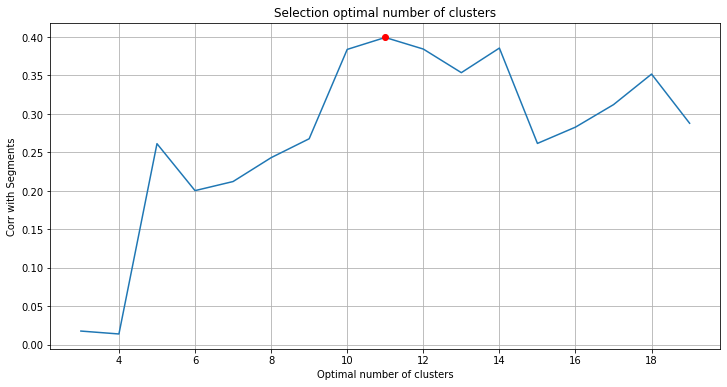

In [87]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(3,20), res)
plt.plot(np.argmax(res)+3, res[np.argmax(res)],'ro')
plt.grid()
plt.ylabel('Corr with Segments')
plt.xlabel('Optimal number of clusters')
plt.title('Selection optimal number of clusters')
print('Optimal num of clusters is ', np.argmax(res)+3)

In [89]:
qty_clust = 11
model_clust = KMeans(n_clusters=qty_clust, algorithm="elkan").fit(train_data)
train['cluster'] = model_clust.predict(train_data)

In [90]:
train[['Segment','cluster']].phik_matrix()

interval columns not set, guessing: ['Segment', 'cluster']


,Segment,cluster
Segment,1.000000,0.393999
cluster,0.393999,1.000000


interval columns not set, guessing: ['Segment', 'cluster']


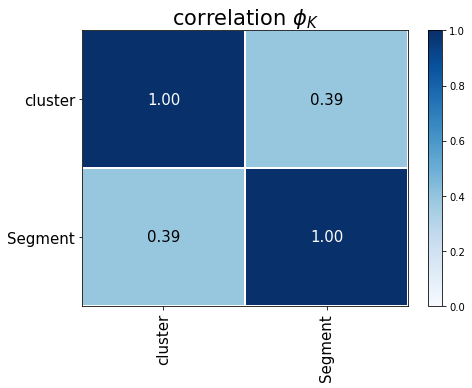

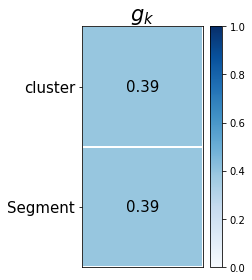

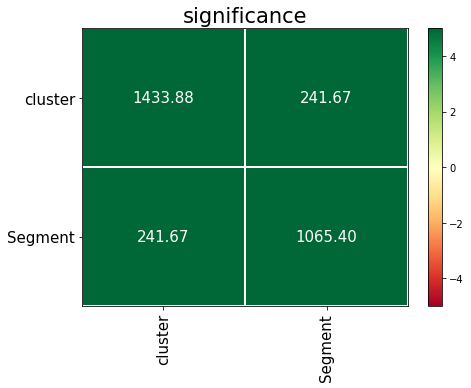

(          Segment   cluster
 Segment  1.000000  0.393999
 cluster  0.393999  1.000000, array([[0.39399932],
        [0.39399932]]),              Segment      cluster
 Segment  1065.396621   241.666646
 cluster   241.666646  1433.882481, {}, {'all': 'corr.pdf'})

In [91]:
report.correlation_report(train[['Segment','cluster']], pdf_file_name='corr.pdf')

In [92]:
from sklearn.manifold import TSNE
import seaborn as sns

In [93]:
train[cols].head()

,hour,dayofweek,day,oblast
18414793,0,1,6,41
32089564,13,4,9,62
1061626,18,5,10,41
14377124,12,2,4,55
16187180,11,4,17,58


In [94]:
%%time
new_train = train.sample(frac=0.01)
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(new_train[cols])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


CPU times: user 59.3 s, sys: 714 ms, total: 60 s
Wall time: 30.9 s


Расположение выданных сегментов


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


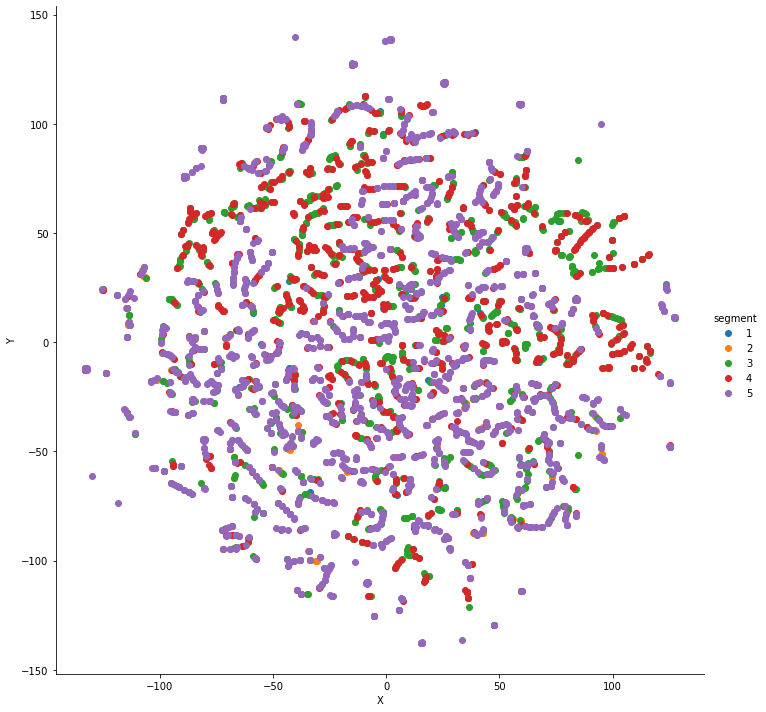

In [95]:
print('Расположение выданных сегментов')

vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'segment' : new_train['Segment']})
sns.FacetGrid(vis_df, hue="segment", size=10).map(plt.scatter, "X", "Y").add_legend()

Результаты кластеризации на 2D


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


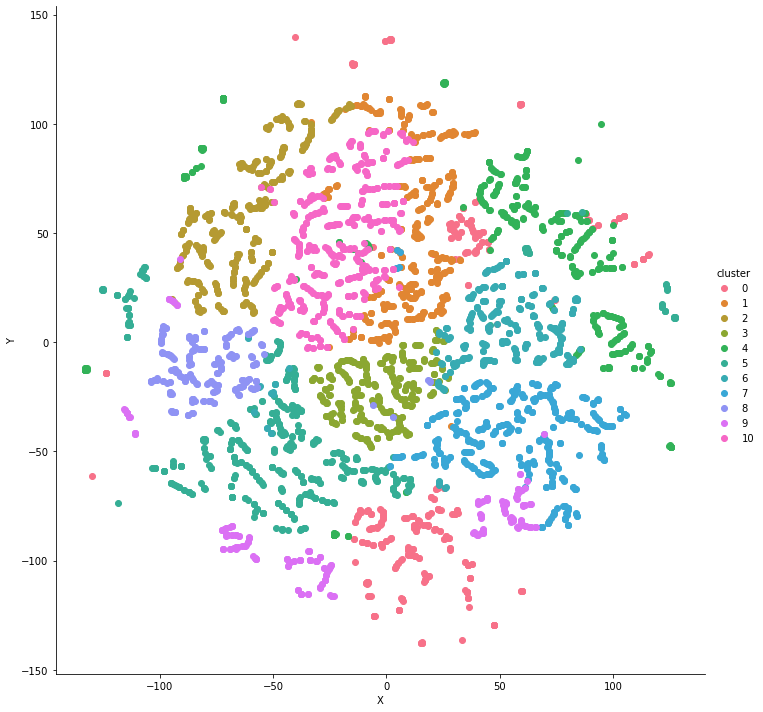

In [96]:
print('Результаты кластеризации на 2D')
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'cluster' : new_train['cluster']})
sns.FacetGrid(vis_df, hue="cluster", size=10).map(plt.scatter, "X", "Y").add_legend()

In [163]:
perc_res = pd.pivot_table(train[['Segment', 'cluster', 'oblast']], index='cluster', columns='Segment', values='oblast', aggfunc='count').fillna(0)
perc_res['sum_row'] = perc_res.sum(axis=1)
perc_res.head()

Segment,1,2,3,4,5,sum_row
cluster,,,,,,
0,814.0,7.0,11192.0,10764.0,16121.0,38898.0
1,1035.0,1.0,12645.0,13119.0,19172.0,45972.0
2,1098.0,0.0,12764.0,13236.0,13675.0,40773.0
3,789.0,0.0,10871.0,11588.0,13144.0,36392.0
4,1141.0,22.0,18476.0,15380.0,11467.0,46486.0


In [164]:
for i in [1,2,3,4,5]:
  perc_res[i] /= perc_res['sum_row']

In [166]:
for i in [1,2,3,4,5]:
  perc_res[i] *= 100

In [167]:
print('Процент каждого сегмента в выявленных кластерах')
(perc_res).round(2)

Процент каждого сегмента в выявленных кластерах


Segment,1,2,3,4,5,sum_row
cluster,,,,,,
0,2.09,0.02,28.77,27.67,41.44,38898.0
1,2.25,0.00,27.51,28.54,41.70,45972.0
2,2.69,0.00,31.31,32.46,33.54,40773.0
3,2.17,0.00,29.87,31.84,36.12,36392.0
4,2.45,0.05,39.75,33.09,24.67,46486.0
5,1.28,8.96,28.35,11.75,49.66,54989.0
6,2.48,0.41,33.50,29.81,33.80,37277.0
7,1.48,9.22,28.91,11.90,48.48,50382.0
8,1.80,9.42,29.82,12.79,46.17,21705.0
